In [161]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib

In [162]:
prokaryotes = pd.read_csv('./data/prokaryotes_348columns.csv')
droplist = [1,3,4,5,6,9,10,12,13,14,15,16,17,18]
prokaryotes = prokaryotes.drop(prokaryotes.columns[droplist], axis=1)

C:\Users\tobia\AppData\Local\Temp\ipykernel_9844\3376044265.py:1: DtypeWarning: Columns (6,19,20,21,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  prokaryotes = pd.read_csv('./data/prokaryotes_348columns.csv')


In [163]:
correlation = prokaryotes.corr(numeric_only=True)['meltPoint'].sort_values(ascending=False)
prokaryotescrystal = prokaryotes.dropna(subset=['Helix1','Sheet1','Turn1'],thresh=1)
crystallcorr = prokaryotescrystal.corr(numeric_only=True)['meltPoint']

In [164]:
highpos = correlation[correlation > 0.3]
highposcry = crystallcorr[crystallcorr > 0.3]

In [165]:
highpos

meltPoint    1.000000
YR           0.492442
RP           0.480594
RG           0.442533
R            0.432905
WR           0.392523
YP           0.390709
LR           0.386596
FR           0.376553
VR           0.370241
ER           0.369174
RC           0.357052
MR           0.343496
P            0.340082
PG           0.338434
EAmotif      0.332202
LP           0.330337
EP           0.328569
Rhelix       0.327399
RH           0.326193
AR           0.324355
ARmotif      0.324100
NR           0.323378
RAmotif      0.317970
LY           0.310896
RLmotif      0.306354
ALmotif      0.305852
YG           0.301671
LG           0.301178
Name: meltPoint, dtype: float64

In [166]:
for n in prokaryotes.index:
    if prokaryotes.loc[n,'meltPoint'] <= prokaryotes['meltPoint'].quantile(0.1):
        prokaryotes.loc[n, 'meltPoint2'] = 'low_Tm'
    elif prokaryotes.loc[n,'meltPoint'] >= prokaryotes['meltPoint'].quantile(0.45) and prokaryotes.loc[n,'meltPoint'] <= prokaryotes['meltPoint'].quantile(0.55):
        prokaryotes.loc[n, 'meltPoint2'] = 'mid_Tm'
    elif prokaryotes.loc[n,'meltPoint'] >= prokaryotes['meltPoint'].quantile(0.9):
        prokaryotes.loc[n, 'meltPoint2'] = 'high_Tm'
    else:
        prokaryotes.loc[n, 'meltPoint2'] = np.nan

C:\Users\tobia\AppData\Local\Temp\ipykernel_9844\3953607476.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'mid_Tm' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  prokaryotes.loc[n, 'meltPoint2'] = 'mid_Tm'


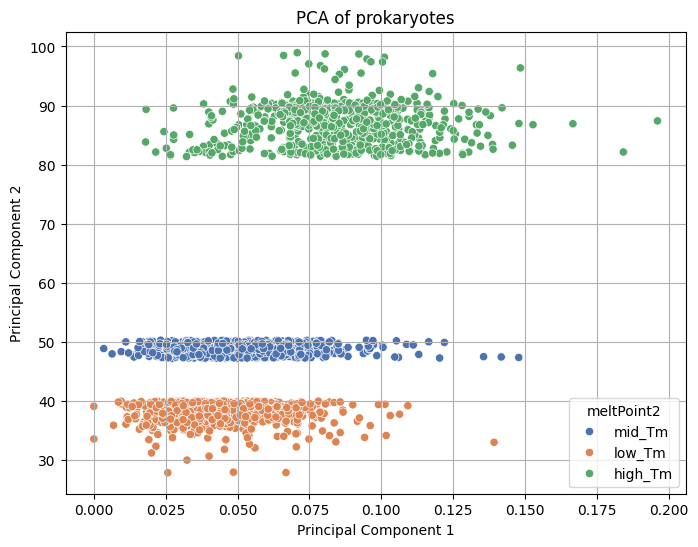

In [167]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data = prokaryotes[prokaryotes['meltPoint2'].isin(['high_Tm','mid_Tm','low_Tm'])], x = 'R', y = 'meltPoint', hue = 'meltPoint2',palette = 'deep')
#sns.scatterplot(data = prokaryotes_PCA_df, x = 'PC1', y = 'PC3', hue = 'meltPoint',palette = 'deep')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of prokaryotes')
plt.grid()
plt.show()

In [168]:
path = './data'
prokaryotespca = pd.read_csv(os.path.join(path, 'prokaryotes_348columns.csv'))
droplist = [0,1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,35,36,37,40,41,42,45,306,327]
droplistmp = [0,1,2,3,4,5,6,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,35,36,37,40,41,42,45,306,327]
prokaryotesmp = prokaryotespca.drop(prokaryotespca.columns[droplistmp], axis=1)
prokaryotespca = prokaryotespca.drop(prokaryotespca.columns[droplist], axis=1)
prokaryotespca.replace([np.inf, -np.inf], np.nan, inplace=True)
prokaryotespca = prokaryotespca.fillna(0)
prokaryotespca = prokaryotespca.reset_index(drop=True)
prokaryotespca2 = prokaryotespca.copy()

C:\Users\tobia\AppData\Local\Temp\ipykernel_9844\536959991.py:2: DtypeWarning: Columns (6,19,20,21,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  prokaryotespca = pd.read_csv(os.path.join(path, 'prokaryotes_348columns.csv'))


In [169]:
pca = PCA(n_components = 25)
scaler = StandardScaler()
prokaryotesscaled = scaler.fit_transform(prokaryotespca)
PCA_prokaryotes = PCA().fit(prokaryotesscaled)
eigenvalues = PCA_prokaryotes.explained_variance_
variance = PCA_prokaryotes.explained_variance_ratio_
prokaryotes_PCA = pca.fit_transform(prokaryotesscaled)
prokaryotes_PCA_df = pd.DataFrame(data = prokaryotes_PCA, columns = [f'PC{i+1}' for i in range(25)])

In [170]:
q1 = prokaryotesmp['meltPoint'].quantile(0.25)
q2_low = prokaryotesmp['meltPoint'].quantile(0.385)
q2_high = prokaryotesmp['meltPoint'].quantile(0.625)
q3 = prokaryotesmp['meltPoint'].quantile(0.75)
def categorize_meltpoint(meltpoint):
    if meltpoint <= q1:
        return 'low_Tm'
    elif q2_low <= meltpoint <= q2_high:
        return 'mid_Tm'
    elif meltpoint >= q3:
        return 'high_Tm'
    else:
        return 'other'

In [171]:
prokaryotes_PCA_df['meltPointGroup'] = prokaryotesmp['meltPoint'].apply(categorize_meltpoint)

In [172]:
################## to do: PCA plots (PC1 vs PC2 scatter, PC1 barplot maybe) ##################

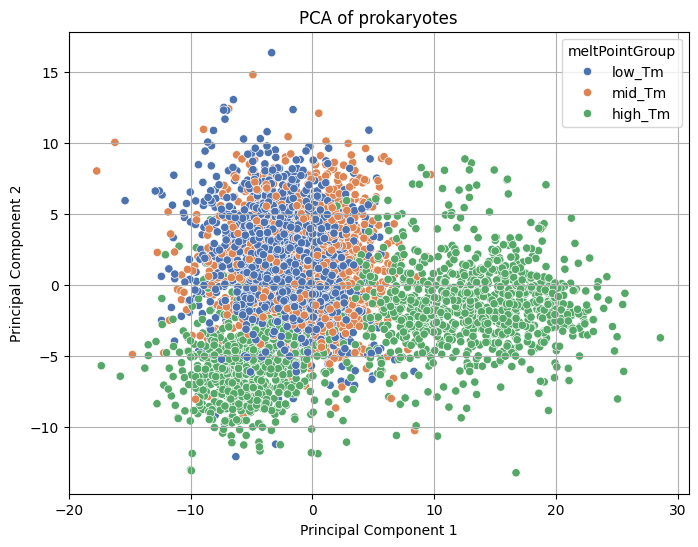

In [173]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data = prokaryotes_PCA_df[prokaryotes_PCA_df['meltPointGroup'].isin(['high_Tm','mid_Tm','low_Tm'])], x = 'PC1', y = 'PC2', hue = 'meltPointGroup',palette = 'deep')
#sns.scatterplot(data = prokaryotes_PCA_df, x = 'PC1', y = 'PC3', hue = 'meltPoint',palette = 'deep')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of prokaryotes')
plt.grid()
plt.show()

In [174]:
loadings = PCA(n_components=25).fit(prokaryotesscaled).components_.T
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=prokaryotespca2.columns)

In [175]:
subsetpc = loadings_df[(loadings_df['PC1'] >= loadings_df['PC1'].quantile(0.9)) | (loadings_df['PC2'] <= loadings_df['PC2'].quantile(0.1))][['PC1','PC2']]

In [176]:
subsetpc  # featurse with high positive or high negative impact on PC1 or PC2

,PC1,PC2
Sheet2perc,-0.007741,-0.066896
AL,0.107701,0.120858
AR,0.121211,0.040023
AP,0.107432,0.091102
VL,0.106099,0.078882
VY,0.018455,-0.069101
VR,0.110776,-0.040403
VP,0.093174,0.016873
ID,-0.114483,-0.094229
IC,-0.107943,-0.065248


In [177]:
subsetpc2 = loadings_df[(loadings_df['PC1'] >= loadings_df['PC1'].quantile(0.8)) & (loadings_df['PC2'] <= loadings_df['PC2'].quantile(0.2))][['PC1','PC2']]

In [178]:
subsetpc2   # features with high positive and high negative impact on PC1 and PC2

,PC1,PC2
VR,0.110776,-0.040403
MR,0.085942,-0.064819
FR,0.093844,-0.047732
YR,0.078228,-0.116083
ER,0.098780,-0.086540
EP,0.095171,-0.048901
EG,0.084965,-0.063828
RH,0.102224,-0.040357
RC,0.100975,-0.053209
RG,0.120245,-0.043425


In [179]:
subsetpc.index

Index(['Sheet2perc', 'AL', 'AR', 'AP', 'VL', 'VY', 'VR', 'VP', 'ID', 'IC',
       'LW', 'LE', 'LR', 'LP', 'LG', 'MD', 'MR', 'FR', 'WR', 'WP', 'NR', 'SK',
       'YE', 'YR', 'YG', 'DR', 'DC', 'ER', 'EP', 'EG', 'RH', 'RK', 'RC', 'RP',
       'RG', 'PG', 'I', 'L', 'N', 'Y', 'D', 'E', 'R', 'K', 'P', 'ALmotif',
       'ARmotif', 'IEmotif', 'YNmotif', 'EAmotif', 'RAmotif', 'RLmotif',
       'ChargedAA', 'Yhelix', 'Ehelix', 'Khelix', 'Isheet', 'Ysheet',
       'Ksheet'],
      dtype='object')

In [180]:
loadings12 = loadings[:,[0,1]]
loadings12sort = loadings12[loadings12[:, 0].argsort()][::-1][0:10,:]

C:\Users\tobia\AppData\Local\Temp\ipykernel_9844\4116125523.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = subsetpc, x = 'PC1', y = 'PC2',palette = 'deep')
C:\Users\tobia\AppData\Local\Temp\ipykernel_9844\4116125523.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x=subsetpc.PC1[i], y=subsetpc.PC2[i], s=subsetpc.index[i],


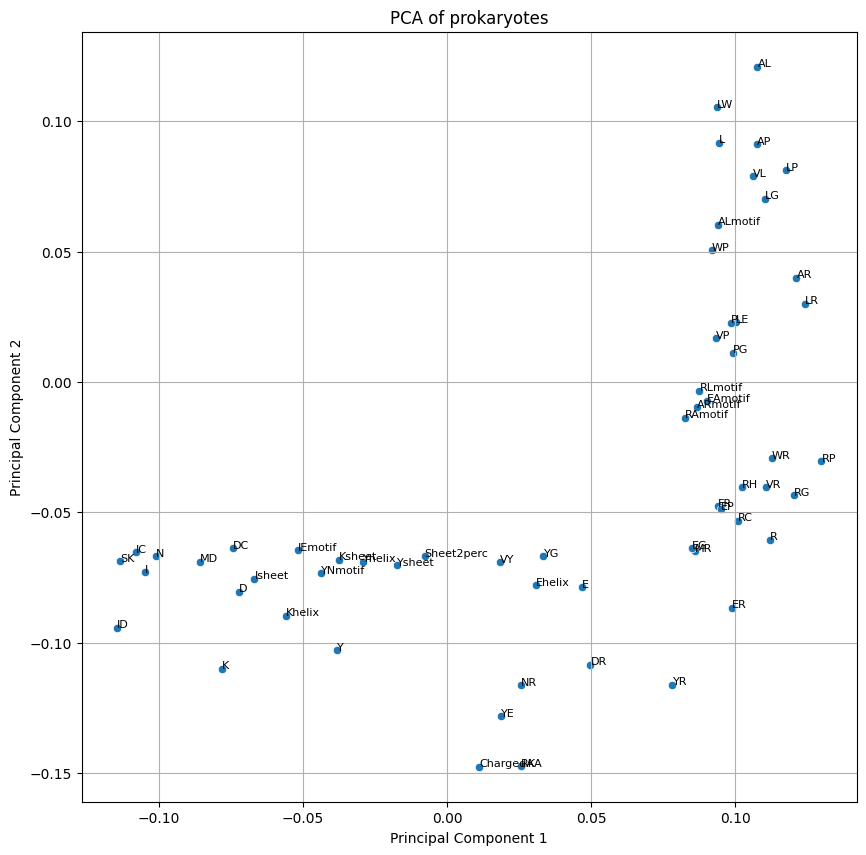

In [181]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data = subsetpc, x = 'PC1', y = 'PC2',palette = 'deep')
#sns.scatterplot(data = prokaryotes_PCA_df, x = 'PC1', y = 'PC3', hue = 'meltPoint',palette = 'deep')
for i in range(subsetpc.shape[0]):
    plt.text(x=subsetpc.PC1[i], y=subsetpc.PC2[i], s=subsetpc.index[i],
            fontdict=dict(color='black', size=8))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of prokaryotes')
plt.grid()
plt.show()

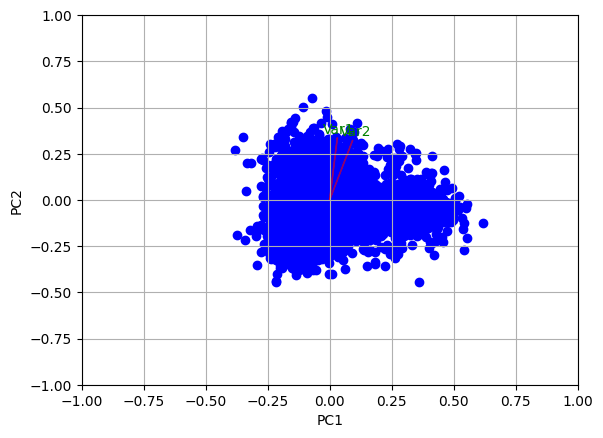

In [186]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
y = prokaryotes_PCA_df['meltPointGroup']
def PCA_Biplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = 'b')
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0]*10, coeff[i,1]*10,color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15*10, coeff[i,1] * 1.15*10, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15*10, coeff[i,1] * 1.15*10, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

#Call the function. Use only the 2 PCs.
PCA_Biplot(prokaryotes_PCA[:,0:2],loadings[0:2, 0:10])
plt.show()